# Strategies for computational scaling

In [1]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm.classes import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.forest import RandomForestRegressor

## Training latencies for different models

Perdiction latencies: https://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py

In [2]:
def generate_dataset(n_samples, n_features, noise=0.1):
    
    print("generating dataset...")

    X, y, coef = make_regression(n_samples=n_samples,
                                 n_features=n_features, 
                                 noise=noise, coef=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
    y_test = y_scaler.transform(y_test[:, None])[:, 0]

    gc.collect()
    
    print('dataset generation complete...')
    
    return X_train, y_train, X_test, y_test

def build_and_train_model(X_train, y_train, model):
    
    training_latencies = []
    
    for i in range(20):
        start = time.time()
        model.fit(X_train, y_train)
        
        training_latencies.append(time.time() - start)
        
   
    return training_latencies

In [3]:
X_train, y_train, X_test, y_test = generate_dataset(10000, 100)

generating dataset...
dataset generation complete...


In [4]:
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.8)
sgd_model = SGDRegressor(penalty='elasticnet', alpha=0.01,
                         l1_ratio=0.25, tol=1e-4)
sv_model = SVR(kernel='rbf', gamma='scale')
dt_model = DecisionTreeRegressor(max_depth=10)
rf_model = RandomForestRegressor(n_estimators=20)

In [5]:
training_latencies_dict = {}
training_latencies_dict['linear'] = build_and_train_model(X_train,
                                                          y_train,
                                                          linear_model)
training_latencies_dict['lasso'] = build_and_train_model(X_train,
                                                         y_train,
                                                         lasso_model)
training_latencies_dict['sgd'] = build_and_train_model(X_train,
                                                       y_train,
                                                       sgd_model)
training_latencies_dict['sv'] = build_and_train_model(X_train,
                                                      y_train,
                                                      sv_model)
training_latencies_dict['dt'] = build_and_train_model(X_train,
                                                      y_train,
                                                      dt_model)
training_latencies_dict['rf'] = build_and_train_model(X_train,
                                                      y_train,
                                                      rf_model)

In [6]:
training_latencies_df = pd.DataFrame()
for key in training_latencies_dict:
    training_latencies_df[key] = training_latencies_dict[key]
training_latencies_df    

,linear,lasso,sgd,sv,dt,rf
0,0.059685,0.017000,0.064035,3.097007,0.460400,7.047342
1,0.047000,0.013000,0.058967,2.997034,0.461070,7.227702
2,0.044998,0.014000,0.088002,2.960001,0.463115,7.161645
3,0.044001,0.012002,0.061996,3.115500,0.461446,7.043864
4,0.047999,0.011998,0.063034,3.130110,0.462071,6.996443
5,0.044000,0.015000,0.060993,3.100985,0.464055,7.187236
6,0.045000,0.013000,0.060998,3.116422,0.461163,7.030272
7,0.043000,0.014005,0.061007,3.110548,0.460983,7.127899
8,0.045001,0.015996,0.058969,3.403304,0.464807,6.810879
9,0.045000,0.011998,0.060032,3.089869,0.495466,6.901990


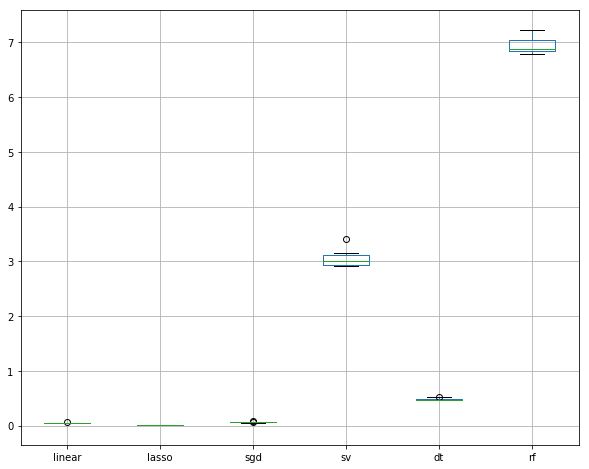

In [7]:
training_latencies_df.boxplot(figsize=(10, 8))